In [30]:
import cellpose
import mitoanalysis
import numpy as np
import os
import matplotlib.pyplot as plt
from cellpose import models, io
from cellpose.io import imread

In [60]:
# list of files
# PUT PATH TO YOUR FILES HERE!
path = '/home/mst3k/mitosisanalyzer/data/')
files = mitoanalysis.get_files(path, fpattern=["*.nd2", "*.tiff", "*.tif"])

example_f = files[-1]
print (example_f)
imgstack,meta = mitoanalysis.nd2_opener(example_f)
mid = len(imgstack)//2
imgslice = imgstack[mid] # np.median(imgstack, axis=0)

/home/khs3z/mitosisanalyzer/data/20240322_MAS91_hcp6RNAi_48hRT006.nd2
metadata['shape']={'t': 210, 'c': 2, 'y': 512, 'x': 512}
imagestack.shape=(210, 2, 512, 512)


In [56]:
io.logger_setup()

# model_type='cyto' or 'nuclei' or 'cyto2' or 'cyto3'
model = models.Cellpose(gpu=True, model_type='cyto3')

# define CHANNELS to run segementation on
# grayscale=0, R=1, G=2, B=3
# channels = [cytoplasm, nucleus]
# if NUCLEUS channel does not exist, set the second channel to 0
channels = [[0,0]]
# IF ALL YOUR IMAGES ARE THE SAME TYPE, you can give a list with 2 elements
# channels = [0,0] # IF YOU HAVE GRAYSCALE
# channels = [2,3] # IF YOU HAVE G=cytoplasm and B=nucleus
# channels = [2,1] # IF YOU HAVE G=cytoplasm and R=nucleus

# if diameter is set to None, the size of the cells is estimated on a per image basis
# you can set the average cell `diameter` in pixels yourself (recommended)
# diameter can be a list or a single number for all images
pixel_diam = 50 / meta["pixel_res"]
masks, flows, styles, diams = model.eval([imgslice], diameter=pixel_diam, channels=channels, cellprob_threshold=1.0)

2024-12-06 08:23:10,685 [INFO] WRITING LOG OUTPUT TO /home/khs3z/.cellpose/run.log
2024-12-06 08:23:10,686 [INFO] 
cellpose version: 	3.0.10 
platform:       	linux 
python version: 	3.10.13 
torch version:  	2.2.1
2024-12-06 08:23:10,705 [INFO] ** TORCH CUDA version installed and working. **
2024-12-06 08:23:10,706 [INFO] >>>> using GPU
2024-12-06 08:23:10,707 [INFO] >> cyto3 << model set to be used
2024-12-06 08:23:10,764 [INFO] >>>> loading model /home/khs3z/.cellpose/models/cyto3
2024-12-06 08:23:10,818 [INFO] >>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)
2024-12-06 08:23:10,822 [INFO] channels set to [[0, 0]]
2024-12-06 08:23:10,822 [INFO] ~~~ FINDING MASKS ~~~
2024-12-06 08:23:11,154 [INFO] >>>> TOTAL TIME 0.33 sec


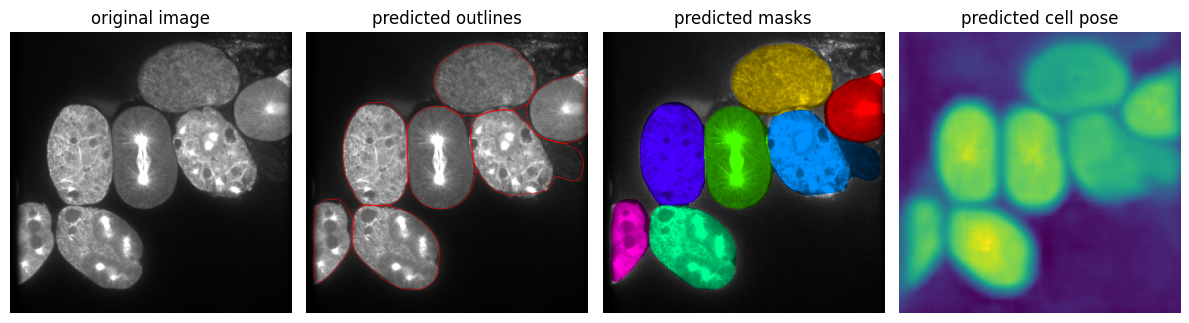

In [57]:
# DISPLAY RESULTS
from cellpose import plot

fig = plt.figure(figsize=(12,5))
ch = 0
plot.show_segmentation(fig, imgslice[0], masks[0], flows[0][2], channels=channels)
plt.tight_layout()
plt.show()